<a href="https://www.kaggle.com/code/jarredpriester/detecting-brain-tumors-vgg16-accuracy-98?scriptVersionId=98657258" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Detecting Brain Tumors in MRIs using a Convolutional Neural Network with Transfer Learning
### Jarred Priester
### 6/17/22

1. Introduction
    * 1.1 Brief overview of task
    * 1.2 Purpose of the Project
    * 1.3 Brief description of dataset

2. Downloading the Data
    * 2.1 Downloading libaries
    * 2.2 Downloading the images
    
3. Processing the Images
    * 3.1 Changing pixel value
    * 3.2 Visualization
    
4. Convolutional Neural Network
    * 4.1 Split data into train, validation, test
    * 4.2 Creating our baseline model
    * 4.3 Adding data agumentation
    * 4.4 Adding a pretrained model

5. Results
    * 5.1 Results table
   
6. Conclusion
    * 6.1 Summary
    * 6.2 Brief thoughts on results
    * 6.3 Futrue work

# 1. Introduction

## 1.1 Brief overview of task

The brain is one of, if not the most important part of our body. Any type of disease involving the brain is very serious. It is very important to detect a tumor not only accurately but as early as possible. Our task will be to take MRI images and accurately predict if the image of the brain has a tumor.

To better understand our task below is a brief explanation of brain tumors from the Mayo Clinic:

*A brain tumor is a mass or growth of abnormal cells in your brain.*

*Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant). Brain tumors can begin in your brain (primary brain tumors), or cancer can begin in other parts of your body and spread to your brain as secondary (metastatic) brain tumors.*

*How quickly a brain tumor grows can vary greatly. The growth rate as well as the location of a brain tumor determines how it will affect the function of your nervous system.*

*Brain tumor treatment options depend on the type of brain tumor you have, as well as its size and location.*

## 1.2 Purpose of the project

The purpose of this project will be to create a convolutional neural network that can classify a MRI of the brain into two catagories: tumor, no tumor. We will start with a baseline model. From there we use data agumentation to add data. Then we will apply transfer learning to improve the accuracy. The idea is that the accuracy will improve with each step.

## 1.3 Brief description of dataset

Unfornately we do not have much information about this dataset and where it comes from. This is a limitation to the project but we will still be able to use this data to give us a good idea of how to detect tumors using a convolutional neural network. Furture studies will involve more rigorous and larger dataset. 

# 2. Downloading the Data

## 2.1 Downloading the libaries

In [1]:
#importing libaries
import numpy as np 
import pandas as pd
import random as rd
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.metrics import accuracy
from keras.applications.vgg16 import VGG16

#setting seed for reproducability
from numpy.random import seed
seed(25)
tf.random.set_seed(50)

## 2.2 Downloading the images

In [2]:
# 0 - Normal
# 1 - Tumor

data = [] #creating a list for images
paths = [] #creating a list for paths
labels = [] #creating a list to put our 0 or 1 labels

#staring with the images that have tumors
for r, d, f in os.walk(r'../input/brain-mri-images-for-brain-tumor-detection/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(1)

#now working with the images with no tumors        
paths = []
for r, d, f in os.walk(r"../input/brain-mri-images-for-brain-tumor-detection/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(0)
        
data = np.array(data)
data.shape

labels = np.array(labels)
labels = labels.reshape(139,1)

print('data shape is:', data.shape)
print('labels shape is:', labels.shape)

data shape is: (139, 128, 128, 3)
labels shape is: (139, 1)


# 3. Processing the images

In [3]:
#we have 139 images with 128 height, 128 weight, RGB color channel
print(data.shape)

(139, 128, 128, 3)


## 3.1 Changing pixel values

Each pixel has a value between 255 and 0. We will reduce this down to 1 and 0 in order to help the neural network converge quicker.

In [4]:
#getting the max of the array
print(np.max(data))
#getting the min of the array
print(np.min(data))

255
0


In [5]:
#reducing the data to between 1 and 0
data = data / 255.00
#getting the max of the array
print(np.max(data))
#getting the min of the array
print(np.min(data))

1.0
0.0


## 3.2 Visualizing the images

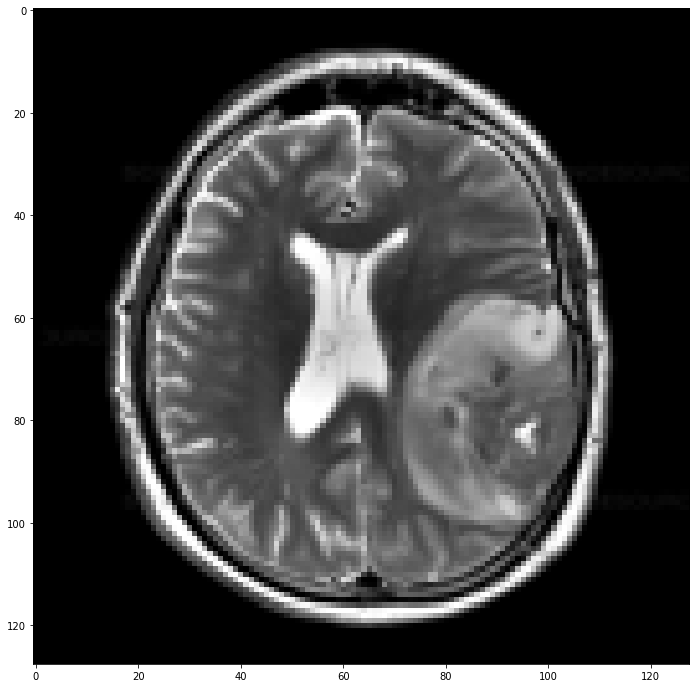

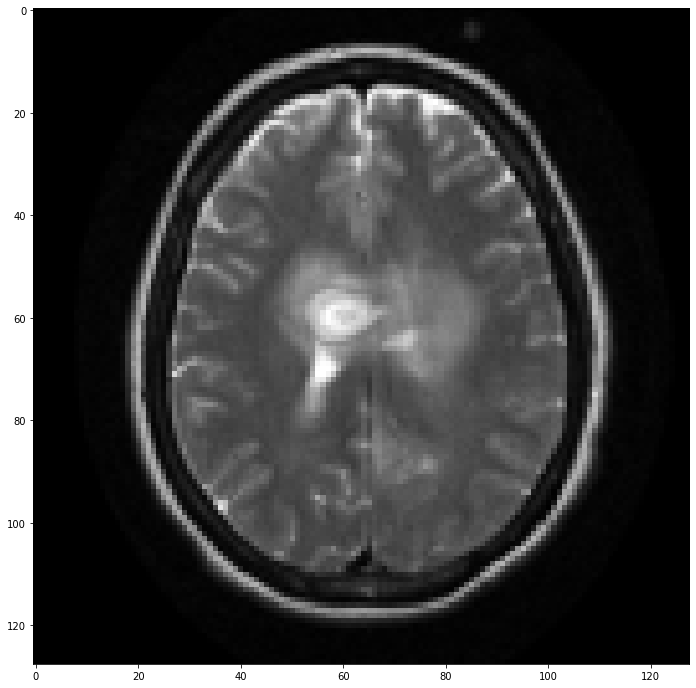

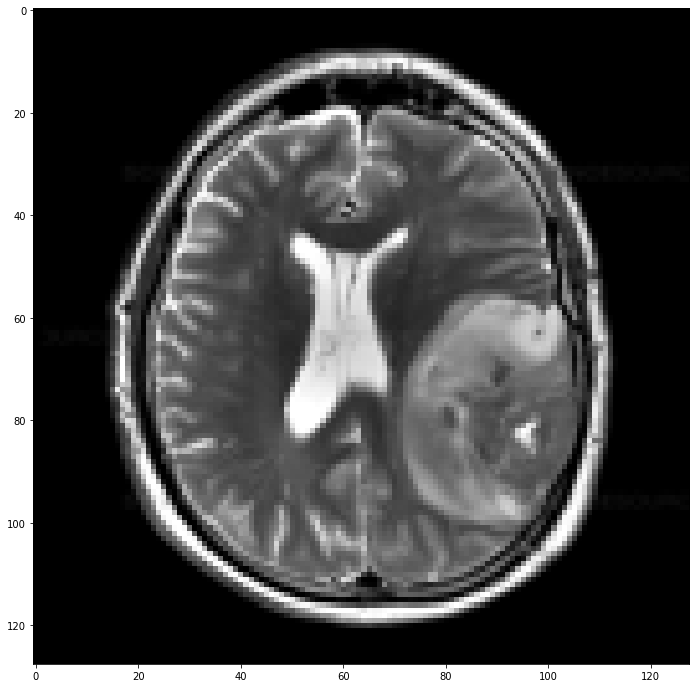

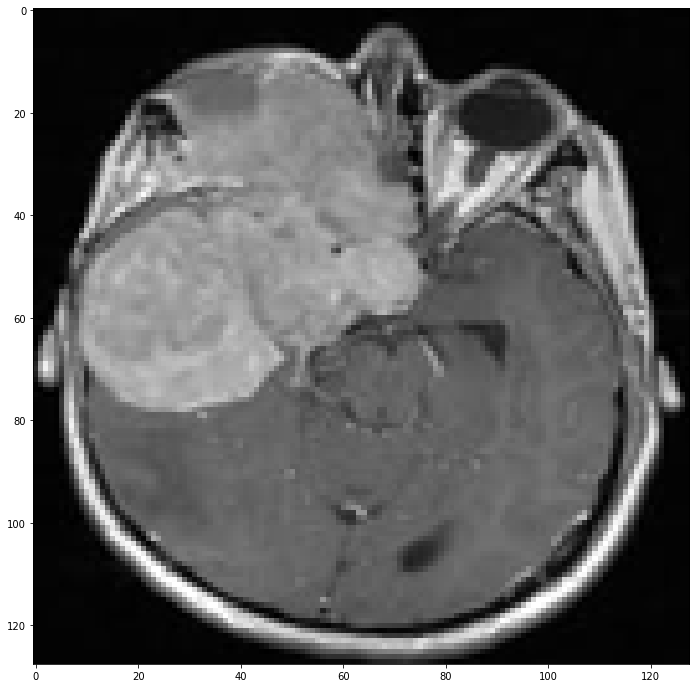

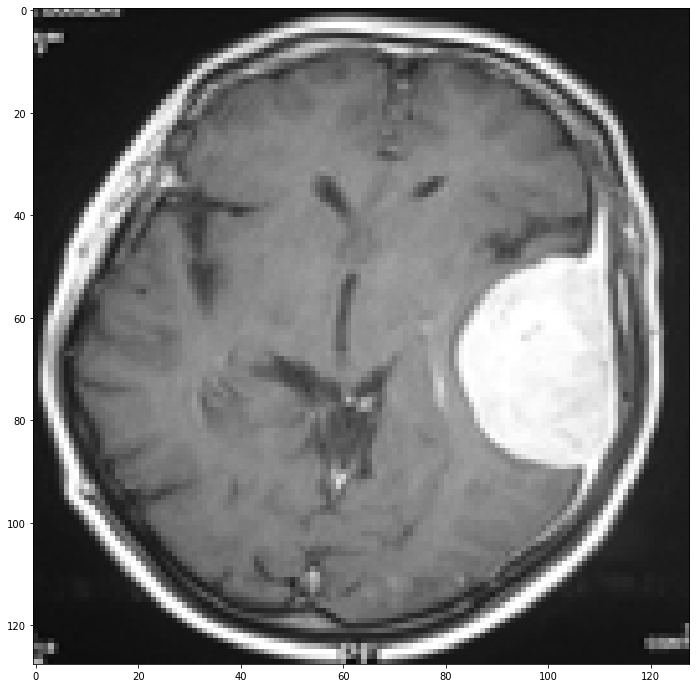

In [6]:
for i in range(5):
    fig = plt.figure(figsize=(70,70))
    plt.subplot(5,5,i+1)
    image = plt.imshow(data[i])
    plt.show(image)

# 4 Model

## 4.1 Creating training and test sets

Before we create our model we will split up the data into traing sets and test sets with 70% going to training and 30% going to testing.

In [7]:
x_train,x_test,y_train,y_test = train_test_split(data, labels, test_size=0.3, shuffle=True, random_state=7)

In [8]:
print("shape of our training data:",x_train.shape)
print("shape of our training labels:",y_train.shape)
print("shape of our test data:",x_test.shape)
print("shape of our test labels:",y_test.shape)

shape of our training data: (97, 128, 128, 3)
shape of our training labels: (97, 1)
shape of our test data: (42, 128, 128, 3)
shape of our test labels: (42, 1)


## 4.2 Creating our baseline model

We will start with creating a sequential model set up for binary classification using the keras libary.

In [9]:
model = keras.Sequential([
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

2022-06-18 03:32:25.810198: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [11]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_test,y_test),
    batch_size = 64,
    epochs=200,
    callbacks=[early_stopping],
    verbose=(2),
)

2022-06-18 03:32:26.138049: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
2/2 - 3s - loss: 0.6920 - accuracy: 0.5155 - val_loss: 0.6946 - val_accuracy: 0.4286
Epoch 2/200
2/2 - 1s - loss: 0.6908 - accuracy: 0.5361 - val_loss: 0.6942 - val_accuracy: 0.4286
Epoch 3/200
2/2 - 1s - loss: 0.6909 - accuracy: 0.5361 - val_loss: 0.6938 - val_accuracy: 0.4286
Epoch 4/200
2/2 - 1s - loss: 0.6881 - accuracy: 0.5258 - val_loss: 0.6932 - val_accuracy: 0.4286
Epoch 5/200
2/2 - 1s - loss: 0.6872 - accuracy: 0.5361 - val_loss: 0.6926 - val_accuracy: 0.4286
Epoch 6/200
2/2 - 1s - loss: 0.6873 - accuracy: 0.5361 - val_loss: 0.6920 - val_accuracy: 0.4286
Epoch 7/200
2/2 - 1s - loss: 0.6872 - accuracy: 0.5361 - val_loss: 0.6914 - val_accuracy: 0.4286
Epoch 8/200
2/2 - 1s - loss: 0.6861 - accuracy: 0.5361 - val_loss: 0.6907 - val_accuracy: 0.4286
Epoch 9/200
2/2 - 1s - loss: 0.6830 - accuracy: 0.5361 - val_loss: 0.6899 - val_accuracy: 0.4286
Epoch 10/200
2/2 - 1s - loss: 0.6831 - accuracy: 0.5361 - val_loss: 0.6892 - val_accuracy: 0.4286
Epoch 11/200
2/2 - 1s - loss:

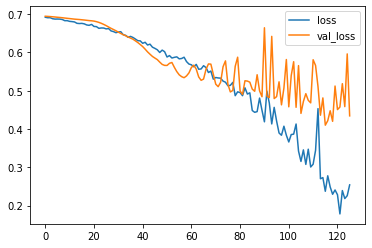

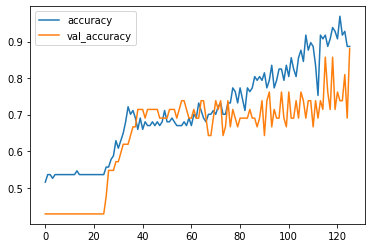

In [12]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

In [13]:
pred = model.predict(x_test)

for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0
     
pred = pred.astype(int)

In [14]:
#creating a classification report
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.88      0.88      0.88        24\n           1       0.83      0.83      0.83        18\n\n    accuracy                           0.86        42\n   macro avg       0.85      0.85      0.85        42\nweighted avg       0.86      0.86      0.86        42\n'

## 4.3 Adding data agumentation

Here we will add a technique called data agumentation. We will be adding a layer that flips our images horizontaly creating more data for our model to train on.

In [15]:
model = keras.Sequential([
    
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to revent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)

In [17]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_test,y_test),
    batch_size = 64,
    epochs=200,
    callbacks=[early_stopping],
    verbose=(2),
)

Epoch 1/200
2/2 - 3s - loss: 0.6997 - accuracy: 0.4536 - val_loss: 0.6928 - val_accuracy: 0.5714
Epoch 2/200
2/2 - 1s - loss: 0.6956 - accuracy: 0.5258 - val_loss: 0.6918 - val_accuracy: 0.4524
Epoch 3/200
2/2 - 1s - loss: 0.6945 - accuracy: 0.5052 - val_loss: 0.6909 - val_accuracy: 0.5238
Epoch 4/200
2/2 - 1s - loss: 0.6909 - accuracy: 0.5052 - val_loss: 0.6905 - val_accuracy: 0.4524
Epoch 5/200
2/2 - 1s - loss: 0.6929 - accuracy: 0.4742 - val_loss: 0.6903 - val_accuracy: 0.4286
Epoch 6/200
2/2 - 1s - loss: 0.6871 - accuracy: 0.5464 - val_loss: 0.6903 - val_accuracy: 0.4286
Epoch 7/200
2/2 - 1s - loss: 0.6803 - accuracy: 0.5361 - val_loss: 0.6910 - val_accuracy: 0.4286
Epoch 8/200
2/2 - 1s - loss: 0.6894 - accuracy: 0.5361 - val_loss: 0.6915 - val_accuracy: 0.4286
Epoch 9/200
2/2 - 1s - loss: 0.6833 - accuracy: 0.5361 - val_loss: 0.6914 - val_accuracy: 0.4286
Epoch 10/200
2/2 - 1s - loss: 0.6742 - accuracy: 0.5361 - val_loss: 0.6912 - val_accuracy: 0.4286
Epoch 11/200
2/2 - 1s - loss:

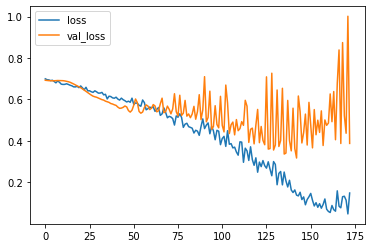

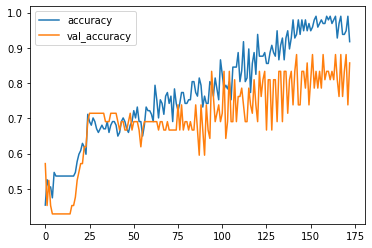

In [18]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

In [19]:
pred = model.predict(x_test)

for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0

pred = pred.astype(int)

In [20]:
#creating a classification report
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.95      0.83      0.89        24\n           1       0.81      0.94      0.87        18\n\n    accuracy                           0.88        42\n   macro avg       0.88      0.89      0.88        42\nweighted avg       0.89      0.88      0.88        42\n'

## 4.4 Adding a pretrained model

First we will load a pretrained model named vgg16.

In [21]:
# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=(128,128,3)
)

Now we will replace our convolutional blocks with the vgg16 model.

In [22]:
model = keras.Sequential([
    
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    
    base_model, #vgg16
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])


In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to revent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.001,
    restore_best_weights=True,
)

In [24]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_test,y_test),
    batch_size = 64,
    epochs=200,
    callbacks=[early_stopping],
    verbose=(2),
)

Epoch 1/200
2/2 - 30s - loss: 0.8076 - accuracy: 0.4536 - val_loss: 0.7809 - val_accuracy: 0.4286
Epoch 2/200
2/2 - 27s - loss: 0.6470 - accuracy: 0.6186 - val_loss: 0.5910 - val_accuracy: 0.6667
Epoch 3/200
2/2 - 28s - loss: 0.6182 - accuracy: 0.6289 - val_loss: 0.5434 - val_accuracy: 0.7619
Epoch 4/200
2/2 - 27s - loss: 0.5471 - accuracy: 0.7938 - val_loss: 0.6947 - val_accuracy: 0.5476
Epoch 5/200
2/2 - 27s - loss: 0.5487 - accuracy: 0.7113 - val_loss: 0.4779 - val_accuracy: 0.7857
Epoch 6/200
2/2 - 27s - loss: 0.5142 - accuracy: 0.7423 - val_loss: 0.4627 - val_accuracy: 0.8095
Epoch 7/200
2/2 - 27s - loss: 0.4375 - accuracy: 0.7732 - val_loss: 0.5544 - val_accuracy: 0.6905
Epoch 8/200
2/2 - 27s - loss: 0.4043 - accuracy: 0.8351 - val_loss: 0.3632 - val_accuracy: 0.8095
Epoch 9/200
2/2 - 27s - loss: 0.4442 - accuracy: 0.7629 - val_loss: 0.5751 - val_accuracy: 0.6190
Epoch 10/200
2/2 - 27s - loss: 0.4313 - accuracy: 0.7938 - val_loss: 0.2941 - val_accuracy: 0.9286
Epoch 11/200
2/2 - 

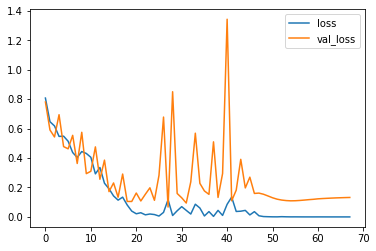

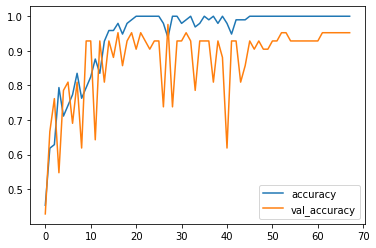

In [25]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

In [26]:
pred = model.predict(x_test)

for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0

pred = pred.astype(int)

In [27]:
#creating a classification report
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.96      1.00      0.98        24\n           1       1.00      0.94      0.97        18\n\n    accuracy                           0.98        42\n   macro avg       0.98      0.97      0.98        42\nweighted avg       0.98      0.98      0.98        42\n'

# 5. Results

## 5.1 Results table

The idea we set out with was to start with a baseline model and add to that model and improve the accuracy with each step. Here is the results of each step:

Model                      |     Accuracy
---------------------------|---------------
Baseline                   |     86%
Adding Data Agumentation   |     89%
Adding Pretrained Model    |     98%

# 6. Conclusion

## 6.1 Summary

We set out with the task of coming up with a model that could predict if a brain MRI image has a tumor or not. We used the keras libary to create a convolutional neural network. We used that as a baseline. From there we added data agumentation to add data. We then added a pretrained model to get our final results. 

## 6.2 Brief thoughts on results

I was pleasantly surprised by the results. I was not sure if we would be able to get an accuracy above 90% with such a small dataset. The transfer learning worked really well!

## 6.3 Future Work

Next step would be to apply this model to a much larger dataset. A much larger data set would allow the model to train off of more cases allowing the model to generalize better. Another step would be to include the different types of tumors and their stages, and to focus on early detection.